# Data preparation

## Setup

In [1]:
## Install required packages
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
#!pip install transformers==4.21.2
#!pip install sentencepiece==0.1.96
#!pip install datasets
#!pip install nltk
#!pip install sentence_transformers
#!pip install gensim


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, classification_report, f1_score
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, DataCollatorForLanguageModeling, AutoModelForMaskedLM, TrainingArguments, Trainer, BertModel
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from datasets import Dataset, DatasetDict
from utils import functions
import random
import nltk
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
import re
from nltk.corpus import stopwords
from gensim.utils import tokenize as tk
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, strip_tags, strip_punctuation, strip_numeric, strip_multiple_whitespaces
from gensim.models import Doc2Vec
from collections import namedtuple
from gensim.models.phrases import Phrases, Phraser
from gensim.models.doc2vec import TaggedDocument


In [3]:
!pip freeze

absl-py==1.3.0
aiohttp==3.8.3
aiosignal==1.3.1
anyio @ file:///C:/ci/anyio_1644481921011/work/dist
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644551690056/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
astunparse==1.6.3
async-timeout==4.0.2
attrs @ file:///opt/conda/conda-bld/attrs_1642510447205/work
Babel @ file:///tmp/build/80754af9/babel_1620871417480/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
beautifulsoup4 @ file:///C:/ci/beautifulsoup4_1650293025093/work
bertopic==0.12.0
bleach @ file:///opt/conda/conda-bld/bleach_1641577558959/work
bokeh @ file:///C:/Windows/TEMP/abs_4a259bc2-ed05-4a1f-808e-ac712cc0900cddqp8sp7/croots/recipe/bokeh_1658136660686/work
Bottleneck @ file:///C:/Windows/Temp/abs_3198ca53-903d-42fd-87b4-03e6d03a8381yfwsuve8/croots/recipe/bottleneck_1657175565403/work
brotlipy==0.7.0
cachetools==5.2.0
certifi @ file:///C:/b/abs_

In [4]:
device = torch.device('cuda')
torch.cuda.get_device_name(device=None)


'NVIDIA GeForce RTX 3090'

In [5]:
## Pseudo-randomness for reproducibility
seed_val = 1234
torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)

## Load data and clean

In [6]:
manifesto = pd.read_csv(os.path.join("data", "r_outputs","manifesto.csv"), encoding="utf-8")


In [7]:
manifesto = manifesto[(manifesto.code.notna()) & ~(manifesto.code.isin(['000','H']))].reset_index(drop=True)

In [8]:
manifesto.head()

,text,cabinet,code,pos,party
0,Wir werden Kriminalität und Gewaltbereitschaft...,1998,605,14,CDU/CSU
1,Die Bürger sollen sich überall in Deutschland ...,1998,605,15,CDU/CSU
2,Der Leitsatz muß lauten: Wehret den Anfängen,1998,605,16,CDU/CSU
3,"Anfänge, das sind die geduldete Ver­wahrlosung...",1998,605,17,CDU/CSU
4,Wir wollen keine Gewöhnung an Ordnungswidrigke...,1998,605,18,CDU/CSU


In [9]:
def extract_code(code):
    if len(code.split('.')) > 1:
        return(int(code.split('.')[0]))
    else:
        return int(code)
manifesto['code_extract'] = manifesto['code'].apply(extract_code)

In [10]:
def sentiment_code(code):
    if code in [104,201,203,305,401,402,407,414,505,601,603,605,606]:
        return('right')
    elif code in [103,105,106,107,202,403,404,406,504,506,701]:
        return('left')
    else:
        return('neutral')

In [11]:
manifesto['sentiment'] = manifesto['code_extract'].apply(sentiment_code)

In [12]:
manifesto.groupby('sentiment').count()

,text,cabinet,code,pos,party,code_extract
sentiment,,,,,,
left,23259,23259,23259,23259,23259,23259
neutral,36691,36691,36691,36691,36691,36691
right,15592,15592,15592,15592,15592,15592


In [13]:
def extract_domain(code):
    return code[0]

In [14]:
manifesto['domain'] = manifesto.code.apply(extract_domain)

In [15]:
manifesto['party_cabinet_sentiment'] = manifesto.party.str.cat(others=[manifesto.cabinet.astype(str), 
manifesto.sentiment.astype(str)], sep='_')
manifesto['party_cabinet'] = manifesto.party.str.cat(others=[manifesto.cabinet.astype(str)], sep='_')
manifesto['party_cabinet_domain'] = manifesto.party.str.cat(others=[manifesto.cabinet.astype(str), 
manifesto.domain.astype(str)], sep='_')

In [16]:
manifesto.groupby('party_cabinet_domain').count()

,text,cabinet,code,pos,party,code_extract,sentiment,domain,party_cabinet_sentiment,party_cabinet
party_cabinet_domain,,,,,,,,,,
CDU/CSU_1998_1,36,36,36,36,36,36,36,36,36,36
CDU/CSU_1998_2,13,13,13,13,13,13,13,13,13,13
CDU/CSU_1998_3,59,59,59,59,59,59,59,59,59,59
CDU/CSU_1998_4,167,167,167,167,167,167,167,167,167,167
CDU/CSU_1998_5,66,66,66,66,66,66,66,66,66,66
...,...,...,...,...,...,...,...,...,...,...
SPD_2021_3,69,69,69,69,69,69,69,69,69,69
SPD_2021_4,368,368,368,368,368,368,368,368,368,368
SPD_2021_5,527,527,527,527,527,527,527,527,527,527


In [17]:
texts = manifesto['text'].tolist()

In [18]:
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 14.587871647560297
Std length (word) is: 7.451678845266895
Min length (word) is: 1
Max length (word) is: 91


In [19]:
for i in range(0,10,2):
    print(i)

0
2
4
6
8


In [20]:
def group_texts(labels_col, text_col, dataset, group_factor=3):
    results = []
    labels = dataset[labels_col].tolist()
    for label in set(labels):
        ls_texts = []
        current_label = dataset[dataset[labels_col] == label]
        print(f'Length of {label} is: {len(current_label)}')
        texts = current_label[text_col].tolist()
        total_length = len(texts)
        total_length = (total_length//group_factor)*group_factor
        for i in range(0,total_length,group_factor):
            text_to_append = ' '.join(texts[i:i+group_factor])
            ls_texts.append(text_to_append)
        result = {
            'sentence_text': ls_texts,
            'labels': label
        }                  
        results.append(result)
    return(results)   

In [21]:
grouped_lists = group_texts('party_cabinet_sentiment', 'text', manifesto)

Length of Greens_2002_right is: 277
Length of PDS/LINKE_2013_left is: 996
Length of Greens_2009_neutral is: 1957
Length of Greens_2005_right is: 337
Length of FDP_1998_right is: 501
Length of CDU/CSU_2013_right is: 720
Length of CDU/CSU_1998_right is: 224
Length of PDS/LINKE_2021_left is: 1992
Length of FDP_2009_neutral is: 1075
Length of CDU/CSU_2009_left is: 385
Length of FDP_2005_left is: 243
Length of CDU/CSU_1998_neutral is: 240
Length of FDP_2005_right is: 484
Length of CDU/CSU_2017_right is: 393
Length of SPD_2017_right is: 480
Length of PDS/LINKE_2013_neutral is: 1179
Length of PDS/LINKE_2017_right is: 287
Length of PDS/LINKE_2021_neutral is: 2337
Length of SPD_2013_right is: 511
Length of Greens_2013_neutral is: 2801
Length of CDU/CSU_2013_neutral is: 1170
Length of SPD_2021_right is: 275
Length of SPD_2017_left is: 897
Length of FDP_2017_neutral is: 762
Length of Greens_2013_right is: 782
Length of FDP_2009_left is: 529
Length of PDS/LINKE_2005_right is: 60
Length of FDP_2013

In [22]:
manifesto_regrouped = pd.DataFrame(grouped_lists)
manifesto_regrouped = manifesto_regrouped.explode('sentence_text').reset_index(drop=True)

In [23]:
manifesto_regrouped['sentence_text'].tolist()[-1]

'Am Anfang ihres Lebens, aber auch wenn sie bereits mitten im Leben stehen. Mit gleicher Förderung vom Beginn eines Lebens an, und allen Bürger*innen die Teilhabe am gesellschaftlichen Leben möglich macht.'

In [24]:
manifesto_regrouped

,sentence_text,labels
0,Wir haben seit unserer Gründung viel Bewegung ...,Greens_2002_right
1,und konnten den Reformstau der Regierung Kohl ...,Greens_2002_right
2,"Haushaltskonsolidierung, BÜNDNIS 90/ DIE GRÜNE...",Greens_2002_right
3,und Menschenrechte. In ihrer Wechselbeziehung ...,Greens_2002_right
4,Als eine der Demokratie verpflichtete Partei s...,Greens_2002_right
...,...,...
25143,und gerechte Steuersysteme unter angemessener ...,SPD_2021_neutral
25144,Auch die VN-Frauenrechtskonvention muss konseq...,SPD_2021_neutral
25145,Wir wollen Industrie- und Innovationsstandort ...,SPD_2021_neutral
25146,und die Möglichkeiten der Digitalisierung basi...,SPD_2021_neutral


In [25]:
manifesto_regrouped.groupby('labels').count()

,sentence_text
labels,
CDU/CSU_1998_left,27
CDU/CSU_1998_neutral,80
CDU/CSU_1998_right,74
CDU/CSU_2002_left,78
CDU/CSU_2002_neutral,183
...,...
SPD_2017_neutral,418
SPD_2017_right,160
SPD_2021_left,221


In [26]:
df_cols = manifesto_regrouped['labels'].str.split('_', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)

In [27]:
manifesto_regrouped.columns = ['sentence_text', 'party_cabinet_sentiment', 'party', 'cabinet','sentiment']

In [28]:
manifesto_regrouped['party_cabinet'] = manifesto_regrouped.party.str.cat(others=[manifesto_regrouped.cabinet], sep='_')
manifesto_regrouped

,sentence_text,party_cabinet_sentiment,party,cabinet,sentiment,party_cabinet
0,Wir haben seit unserer Gründung viel Bewegung ...,Greens_2002_right,Greens,2002,right,Greens_2002
1,und konnten den Reformstau der Regierung Kohl ...,Greens_2002_right,Greens,2002,right,Greens_2002
2,"Haushaltskonsolidierung, BÜNDNIS 90/ DIE GRÜNE...",Greens_2002_right,Greens,2002,right,Greens_2002
3,und Menschenrechte. In ihrer Wechselbeziehung ...,Greens_2002_right,Greens,2002,right,Greens_2002
4,Als eine der Demokratie verpflichtete Partei s...,Greens_2002_right,Greens,2002,right,Greens_2002
...,...,...,...,...,...,...
25143,und gerechte Steuersysteme unter angemessener ...,SPD_2021_neutral,SPD,2021,neutral,SPD_2021
25144,Auch die VN-Frauenrechtskonvention muss konseq...,SPD_2021_neutral,SPD,2021,neutral,SPD_2021
25145,Wir wollen Industrie- und Innovationsstandort ...,SPD_2021_neutral,SPD,2021,neutral,SPD_2021
25146,und die Möglichkeiten der Digitalisierung basi...,SPD_2021_neutral,SPD,2021,neutral,SPD_2021


In [29]:
texts = manifesto_regrouped['sentence_text'].tolist()
len(texts[1].split())

18

In [30]:
mean([len(text.split()) for text in texts])

43.775727692062986

# Proxy task: sentiment classification

## BERT

In [264]:
bert_model = 'results/bert/bert_mlm/checkpoint-1887/'
tokenizer = AutoTokenizer.from_pretrained('deepset/gbert-base')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loading configuration file https://huggingface.co/deepset/gbert-base/resolve/main/config.json from cache at C:\Users\Hung/.cache\huggingface\transformers\0f9d6c73cd85ab98cecc6866492c84f23e72bbaf2240a24da0e5d5e3b8810707.080f0bd0794ab07ca509487675f6cb88cfbdc04fc142b21be92212223e82cb14
Model config BertConfig {
  "_name_or_path": "deepset/gbert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading file https://huggingface.co/deepset/gbert-base/resolve/main/vocab.txt from cache 

In [209]:
manifesto_dataset = Dataset.from_pandas(manifesto_regrouped)
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')
manifesto_dataset = manifesto_dataset.rename_column('sentiment','labels')


Casting to class labels:   0%|          | 0/26 [00:00<?, ?ba/s]

In [210]:
train_test = manifesto_dataset.train_test_split(test_size=0.2, stratify_by_column='labels', seed = seed_val)
train_valid = train_test['train'].train_test_split(test_size=0.25, stratify_by_column='labels', seed = seed_val)

In [211]:
manifesto_datasets = DatasetDict({
    'train': train_valid['train'],
    'test': train_test['test'],
    'valid': train_valid['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence_text', 'party_cabinet_sentiment', 'party', 'cabinet', 'labels', 'party_cabinet'],
        num_rows: 15088
    })
    test: Dataset({
        features: ['sentence_text', 'party_cabinet_sentiment', 'party', 'cabinet', 'labels', 'party_cabinet'],
        num_rows: 5030
    })
    valid: Dataset({
        features: ['sentence_text', 'party_cabinet_sentiment', 'party', 'cabinet', 'labels', 'party_cabinet'],
        num_rows: 5030
    })
})

In [212]:
def tokenize_function(dataset):
    return tokenizer(dataset['sentence_text'], truncation=True, max_length=300)


In [213]:
manifesto_dataset.features['labels']

ClassLabel(names=['left', 'neutral', 'right'], id=None)

In [214]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, batched=True,
remove_columns=['sentence_text','cabinet','party','party_cabinet_sentiment','party_cabinet'])

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [215]:
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [265]:
num_classes = len(set(manifesto['sentiment']))
model = AutoModelForSequenceClassification.from_pretrained(bert_model, num_labels=num_classes).to(device)


loading configuration file results/bert/bert_mlm/checkpoint-1887/config.json
Model config BertConfig {
  "_name_or_path": "results/bert/bert_mlm/checkpoint-1887/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading weights file results/bert/bert_mlm/checkpoint-1887/pytorch_model.bin
Some weights of t

In [266]:
batch_size = 32
training_args = TrainingArguments(
    output_dir="results/bert/bert_3class_std",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps=50,
    num_train_epochs = 3,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [267]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Using cuda_amp half precision backend


In [268]:
trainer.train()

***** Running training *****
  Num examples = 15088
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1416


  0%|          | 0/1416 [00:00<?, ?it/s]

{'loss': 0.9423, 'learning_rate': 2.8961864406779665e-05, 'epoch': 0.11}
{'loss': 0.7651, 'learning_rate': 2.7902542372881356e-05, 'epoch': 0.21}
{'loss': 0.6462, 'learning_rate': 2.6843220338983052e-05, 'epoch': 0.32}
{'loss': 0.5912, 'learning_rate': 2.5783898305084747e-05, 'epoch': 0.42}
{'loss': 0.5972, 'learning_rate': 2.4724576271186443e-05, 'epoch': 0.53}
{'loss': 0.5622, 'learning_rate': 2.3665254237288138e-05, 'epoch': 0.64}
{'loss': 0.56, 'learning_rate': 2.260593220338983e-05, 'epoch': 0.74}
{'loss': 0.5497, 'learning_rate': 2.1546610169491525e-05, 'epoch': 0.85}
{'loss': 0.5187, 'learning_rate': 2.048728813559322e-05, 'epoch': 0.95}


***** Running Evaluation *****
  Num examples = 5030
  Batch size = 32


  0%|          | 0/158 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.7065511640498106, 0.8741126360624705, 0.7214953271028037]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.842479018721756, 0.7557283142389526, 0.7444551591128254]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7685512367491167, 0.8106210226025895, 0.7327954437588989]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.842479018721756, 0.7557283142389526, 0.7444551591128254]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so 

{'eval_loss': 0.5311241149902344, 'eval_precision': [0.7065511640498106, 0.8741126360624705, 0.7214953271028037], 'eval_recall': [0.842479018721756, 0.7557283142389526, 0.7444551591128254], 'eval_f1': [0.7685512367491167, 0.8106210226025895, 0.7327954437588989], 'eval_accuracy': [0.842479018721756, 0.7557283142389526, 0.7444551591128254], 'eval_runtime': 5.1658, 'eval_samples_per_second': 973.721, 'eval_steps_per_second': 30.586, 'epoch': 1.0}


Model weights saved in results/bert/bert_3class_std\checkpoint-472\pytorch_model.bin
tokenizer config file saved in results/bert/bert_3class_std\checkpoint-472\tokenizer_config.json
Special tokens file saved in results/bert/bert_3class_std\checkpoint-472\special_tokens_map.json


{'loss': 0.4856, 'learning_rate': 1.9427966101694916e-05, 'epoch': 1.06}
{'loss': 0.3686, 'learning_rate': 1.836864406779661e-05, 'epoch': 1.17}
{'loss': 0.3943, 'learning_rate': 1.733050847457627e-05, 'epoch': 1.27}
{'loss': 0.3999, 'learning_rate': 1.6271186440677967e-05, 'epoch': 1.38}
{'loss': 0.3866, 'learning_rate': 1.5211864406779662e-05, 'epoch': 1.48}
{'loss': 0.3775, 'learning_rate': 1.4152542372881356e-05, 'epoch': 1.59}
{'loss': 0.363, 'learning_rate': 1.3093220338983051e-05, 'epoch': 1.69}
{'loss': 0.3052, 'learning_rate': 1.2033898305084747e-05, 'epoch': 1.8}
{'loss': 0.3666, 'learning_rate': 1.097457627118644e-05, 'epoch': 1.91}


***** Running Evaluation *****
  Num examples = 5030
  Batch size = 32


  0%|          | 0/158 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.817477096546864, 0.8353730754046585, 0.7625231910946196]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7488702388637831, 0.8657937806873978, 0.7926711668273867]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7816711590296496, 0.8503114325899136, 0.777304964539007]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7488702388637831, 0.8657937806873978, 0.7926711668273867]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so 

{'eval_loss': 0.5007196068763733, 'eval_precision': [0.817477096546864, 0.8353730754046585, 0.7625231910946196], 'eval_recall': [0.7488702388637831, 0.8657937806873978, 0.7926711668273867], 'eval_f1': [0.7816711590296496, 0.8503114325899136, 0.777304964539007], 'eval_accuracy': [0.7488702388637831, 0.8657937806873978, 0.7926711668273867], 'eval_runtime': 5.7871, 'eval_samples_per_second': 869.173, 'eval_steps_per_second': 27.302, 'epoch': 2.0}


Model weights saved in results/bert/bert_3class_std\checkpoint-944\pytorch_model.bin
tokenizer config file saved in results/bert/bert_3class_std\checkpoint-944\tokenizer_config.json
Special tokens file saved in results/bert/bert_3class_std\checkpoint-944\special_tokens_map.json


{'loss': 0.3627, 'learning_rate': 9.915254237288136e-06, 'epoch': 2.01}
{'loss': 0.2221, 'learning_rate': 8.855932203389831e-06, 'epoch': 2.12}
{'loss': 0.1861, 'learning_rate': 7.796610169491525e-06, 'epoch': 2.22}
{'loss': 0.2512, 'learning_rate': 6.737288135593221e-06, 'epoch': 2.33}
{'loss': 0.2074, 'learning_rate': 5.677966101694915e-06, 'epoch': 2.44}
{'loss': 0.2527, 'learning_rate': 4.61864406779661e-06, 'epoch': 2.54}
{'loss': 0.1999, 'learning_rate': 3.5593220338983053e-06, 'epoch': 2.65}
{'loss': 0.1986, 'learning_rate': 2.4999999999999998e-06, 'epoch': 2.75}
{'loss': 0.2142, 'learning_rate': 1.440677966101695e-06, 'epoch': 2.86}
{'loss': 0.1884, 'learning_rate': 3.8135593220338985e-07, 'epoch': 2.97}


***** Running Evaluation *****
  Num examples = 5030
  Batch size = 32


  0%|          | 0/158 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8013289036544851, 0.8424218123496391, 0.7720659553831232]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7785668173014848, 0.8596563011456628, 0.7675988428158148]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7897838899803536, 0.8509518023491293, 0.769825918762089]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7785668173014848, 0.8596563011456628, 0.7675988428158148]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so

{'eval_loss': 0.5623244643211365, 'eval_precision': [0.8013289036544851, 0.8424218123496391, 0.7720659553831232], 'eval_recall': [0.7785668173014848, 0.8596563011456628, 0.7675988428158148], 'eval_f1': [0.7897838899803536, 0.8509518023491293, 0.769825918762089], 'eval_accuracy': [0.7785668173014848, 0.8596563011456628, 0.7675988428158148], 'eval_runtime': 5.2482, 'eval_samples_per_second': 958.424, 'eval_steps_per_second': 30.106, 'epoch': 3.0}


Model weights saved in results/bert/bert_3class_std\checkpoint-1416\pytorch_model.bin
tokenizer config file saved in results/bert/bert_3class_std\checkpoint-1416\tokenizer_config.json
Special tokens file saved in results/bert/bert_3class_std\checkpoint-1416\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/bert/bert_3class_std\checkpoint-944 (score: 0.5007196068763733).


{'train_runtime': 194.0493, 'train_samples_per_second': 233.26, 'train_steps_per_second': 7.297, 'train_loss': 0.4071221654698, 'epoch': 3.0}


TrainOutput(global_step=1416, training_loss=0.4071221654698, metrics={'train_runtime': 194.0493, 'train_samples_per_second': 233.26, 'train_steps_per_second': 7.297, 'train_loss': 0.4071221654698, 'epoch': 3.0})

In [269]:
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 5030
  Batch size = 32


  0%|          | 0/158 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.832468495181616, 0.8094876660341556, 0.754302103250478]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.725452196382429, 0.8727495908346972, 0.7601156069364162]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7752847773558855, 0.8399291199054932, 0.7571976967370442]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.725452196382429, 0.8727495908346972, 0.7601156069364162]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we

0.7908038646661409


In [270]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.78,0.83,0.73,0.73
1,0.84,0.81,0.87,0.87
2,0.76,0.75,0.76,0.76


In [278]:
round(res_table.mean(axis=0),2)

f1           0.79
precision    0.80
recall       0.79
accuracy     0.79
dtype: float64

## Bag-of-words with TF-IDF

In [280]:
## Preprocessing for bag-of-words and word2vec models is a little different (pre-trained)
## Tokenizer - use gensim's tokenizer 
def clean_text(text, stopwords):
    custom_filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, strip_multiple_whitespaces]
    text = preprocess_string(text, custom_filters)
    tokens = [w for w in text if w not in stopwords]
    return ' '.join(tokens)


In [281]:
outputs = []
for idx, text in enumerate(manifesto_regrouped['sentence_text']):
    if idx % 1000 ==0:
        print(f'Cleaning the {idx}th sentence')
    outputs.append(clean_text(text, stopwords.words('german')))

Cleaning the 0th sentence
Cleaning the 1000th sentence
Cleaning the 2000th sentence
Cleaning the 3000th sentence
Cleaning the 4000th sentence
Cleaning the 5000th sentence
Cleaning the 6000th sentence
Cleaning the 7000th sentence
Cleaning the 8000th sentence
Cleaning the 9000th sentence
Cleaning the 10000th sentence
Cleaning the 11000th sentence
Cleaning the 12000th sentence
Cleaning the 13000th sentence
Cleaning the 14000th sentence
Cleaning the 15000th sentence
Cleaning the 16000th sentence
Cleaning the 17000th sentence
Cleaning the 18000th sentence
Cleaning the 19000th sentence
Cleaning the 20000th sentence
Cleaning the 21000th sentence
Cleaning the 22000th sentence
Cleaning the 23000th sentence
Cleaning the 24000th sentence
Cleaning the 25000th sentence


In [224]:
manifesto_regrouped

,sentence_text,party_cabinet_sentiment,party,cabinet,sentiment,party_cabinet
0,Deutschland ist auf einem guten Weg. Trotz der...,FDP_2013_right,FDP,2013,right,FDP_2013
1,Dafür haben wir uns vier Jahre lang in der chr...,FDP_2013_right,FDP,2013,right,FDP_2013
2,Wir haben den Staatshaushalt in Ordnung gebrac...,FDP_2013_right,FDP,2013,right,FDP_2013
3,Wir haben neue Subventionen verhindert und Sta...,FDP_2013_right,FDP,2013,right,FDP_2013
4,"Sicheres Geld. Solide Haushalte. Und starke, f...",FDP_2013_right,FDP,2013,right,FDP_2013
...,...,...,...,...,...,...
25143,Wir werden deshalb auch künftig die Arbeit der...,CDU/CSU_2017_right,CDU/CSU,2017,right,CDU/CSU_2017
25144,"Moscheen, in denen Hass und Gewalt gepredigt w...",CDU/CSU_2017_right,CDU/CSU,2017,right,CDU/CSU_2017
25145,CDU und CSU wollen weiter Verantwortung für De...,CDU/CSU_2017_right,CDU/CSU,2017,right,CDU/CSU_2017
25146,Sie verlangen unser mutiges und vorausschauend...,CDU/CSU_2017_right,CDU/CSU,2017,right,CDU/CSU_2017


In [282]:
manifesto_regrouped['text_cleaned'] = outputs

In [283]:
## Before
manifesto_regrouped.loc[0,'sentence_text']

'Deutschland ist auf einem guten Weg. Trotz der schweren Krise in Europa. Und es ist ein Verdienst liberaler Politik, weil mehr Menschen die Freiheit dazu haben, ihre Träume zu verfolgen und ihren eigenen Weg zu gehen.'

In [227]:
## After
outputs[0]

'deutschland guten trotz schweren krise europa verdienst liberaler politik mehr menschen freiheit träume verfolgen eigenen gehen'

In [284]:
df_train, df_test = train_test_split(manifesto_regrouped, test_size=0.2, stratify = manifesto_regrouped['sentiment'],random_state=seed_val)
df_train, df_eval = train_test_split(df_train, test_size=0.25, stratify = df_train['sentiment'], random_state=seed_val)
enc = OrdinalEncoder()

df_train['labels'] = enc.fit_transform(np.array(df_train['sentiment'].tolist()).reshape(-1,1))
df_test['labels'] = enc.fit_transform(np.array(df_test['sentiment'].tolist()).reshape(-1,1))
df_eval['labels'] = enc.fit_transform(np.array(df_eval['sentiment'].tolist()).reshape(-1,1))

df_train = df_train.reset_index(drop=True)
df_eval = df_eval.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



In [285]:
y_train = np.array(df_train['labels'])
y_eval = np.array(df_eval['labels'])
y_test = np.array(df_test['labels'])

In [286]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [287]:
corp_train = df_train['sentence_text'].tolist()
vectorizer.fit(corp_train)
X_train = vectorizer.transform(corp_train)
dic_vocabulary = vectorizer.vocabulary_

In [288]:
classifier = naive_bayes.MultinomialNB()

In [289]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = df_test["sentence_text"].tolist()
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [290]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted, average=None)
matrix = confusion_matrix(y_test, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [291]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.62,0.74,0.53,0.53
1,0.75,0.64,0.92,0.92
2,0.47,0.81,0.33,0.33


In [292]:
round(res_table.mean(axis=0),2)

f1           0.61
precision    0.73
recall       0.59
accuracy     0.59
dtype: float64

## Doc2Vec


In [236]:
## We train word2vec embeddings on the GermaParl dataset before using embeddings for classification
outputs = []
for idx, text in enumerate(manifesto_regrouped['sentence_text']):
    if idx % 100 ==0:
        print(f'Cleaning the {idx+1}th sentence')
    outputs.append(clean_text(text, stopwords.words('german')))

Cleaning the 1th sentence
Cleaning the 101th sentence
Cleaning the 201th sentence
Cleaning the 301th sentence
Cleaning the 401th sentence
Cleaning the 501th sentence
Cleaning the 601th sentence
Cleaning the 701th sentence
Cleaning the 801th sentence
Cleaning the 901th sentence
Cleaning the 1001th sentence
Cleaning the 1101th sentence
Cleaning the 1201th sentence
Cleaning the 1301th sentence
Cleaning the 1401th sentence
Cleaning the 1501th sentence
Cleaning the 1601th sentence
Cleaning the 1701th sentence
Cleaning the 1801th sentence
Cleaning the 1901th sentence
Cleaning the 2001th sentence
Cleaning the 2101th sentence
Cleaning the 2201th sentence
Cleaning the 2301th sentence
Cleaning the 2401th sentence
Cleaning the 2501th sentence
Cleaning the 2601th sentence
Cleaning the 2701th sentence
Cleaning the 2801th sentence
Cleaning the 2901th sentence
Cleaning the 3001th sentence
Cleaning the 3101th sentence
Cleaning the 3201th sentence
Cleaning the 3301th sentence
Cleaning the 3401th senten

In [237]:
manifesto_regrouped['text_cleaned'] = outputs

In [238]:
manifesto_regrouped

,sentence_text,party_cabinet_sentiment,party,cabinet,sentiment,party_cabinet,text_cleaned
0,Deutschland ist auf einem guten Weg. Trotz der...,FDP_2013_right,FDP,2013,right,FDP_2013,deutschland guten trotz schweren krise europa ...
1,Dafür haben wir uns vier Jahre lang in der chr...,FDP_2013_right,FDP,2013,right,FDP_2013,dafür vier jahre lang christlich liberalen koa...
2,Wir haben den Staatshaushalt in Ordnung gebrac...,FDP_2013_right,FDP,2013,right,FDP_2013,staatshaushalt ordnung gebracht erste mal seit...
3,Wir haben neue Subventionen verhindert und Sta...,FDP_2013_right,FDP,2013,right,FDP_2013,neue subventionen verhindert staatshilfen groß...
4,"Sicheres Geld. Solide Haushalte. Und starke, f...",FDP_2013_right,FDP,2013,right,FDP_2013,sicheres geld solide haushalte starke freie bü...
...,...,...,...,...,...,...,...
25143,Wir werden deshalb auch künftig die Arbeit der...,CDU/CSU_2017_right,CDU/CSU,2017,right,CDU/CSU_2017,deshalb künftig arbeit kirchen vielfältiger we...
25144,"Moscheen, in denen Hass und Gewalt gepredigt w...",CDU/CSU_2017_right,CDU/CSU,2017,right,CDU/CSU_2017,moscheen denen hass gewalt gepredigt denen sal...
25145,CDU und CSU wollen weiter Verantwortung für De...,CDU/CSU_2017_right,CDU/CSU,2017,right,CDU/CSU_2017,cdu csu verantwortung deutschland tragen septe...
25146,Sie verlangen unser mutiges und vorausschauend...,CDU/CSU_2017_right,CDU/CSU,2017,right,CDU/CSU_2017,verlangen mutiges vorausschauendes politisches...


In [293]:
class corpusIterator(object):
    def __init__(self, df, bigram=None, trigram=None):
        if bigram:
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.df = df
    def __iter__(self):
        for  index, row in self.df.iterrows():
            if index % 3000 == 0:
                print(f'Working on the {index+1}th sentence')
            text = row['text_cleaned']
            labels = row['sentiment']
            tokens = text.split()
            if self.bigram and self.trigram:
                self.words = self.trigram[self.bigram[tokens]]
            elif self.bigram and not self.trigram:
                self.words = self.bigram[tokens]
            else:
                self.words = tokens
            yield TaggedDocument(self.words, [labels])
            
class phraseIterator(object):
    def __init__(self, df):
        self.df = df
    def __iter__(self):
        for index, row in self.df.iterrows():
            if index % 3000 == 0:
                print(f'Working on the {index+1}th sentence')
            text = row['text_cleaned']
            yield text.split()

In [294]:
df_train, df_test = train_test_split(manifesto_regrouped, test_size=0.2, stratify = manifesto_regrouped['sentiment'],random_state=seed_val)
df_train, df_eval = train_test_split(df_train, test_size=0.25, stratify = df_train['sentiment'], random_state=seed_val)
enc = OrdinalEncoder()

df_train['labels'] = enc.fit_transform(np.array(df_train['sentiment'].tolist()).reshape(-1,1))
df_test['labels'] = enc.fit_transform(np.array(df_test['sentiment'].tolist()).reshape(-1,1))
df_eval['labels'] = enc.fit_transform(np.array(df_eval['sentiment'].tolist()).reshape(-1,1))

df_train = df_train.reset_index(drop=True)
df_eval = df_eval.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



In [295]:
outputs_stream = phraseIterator(df_train)
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

Working on the 1th sentence
Working on the 3001th sentence
Working on the 6001th sentence
Working on the 9001th sentence
Working on the 12001th sentence
Working on the 15001th sentence
Working on the 1th sentence
Working on the 1th sentence
Working on the 3001th sentence
Working on the 6001th sentence
Working on the 9001th sentence
Working on the 12001th sentence
Working on the 15001th sentence


In [296]:
model = Doc2Vec(vector_size=300, window=5, min_count=1, workers=8, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(df_train, bigram=bigram, trigram=trigram))
model.train(corpusIterator(df_train, bigram=bigram, trigram=trigram), total_examples=model.corpus_count, epochs=model.epochs)

Working on the 1th sentence
Working on the 3001th sentence
Working on the 6001th sentence
Working on the 9001th sentence
Working on the 12001th sentence
Working on the 15001th sentence
Working on the 1th sentence
Working on the 3001th sentence
Working on the 6001th sentence
Working on the 9001th sentence
Working on the 12001th sentence
Working on the 15001th sentence
Working on the 1th sentence
Working on the 3001th sentence
Working on the 6001th sentence
Working on the 9001th sentence
Working on the 12001th sentence
Working on the 15001th sentence
Working on the 1th sentence
Working on the 3001th sentence
Working on the 6001th sentence
Working on the 9001th sentence
Working on the 12001th sentence
Working on the 15001th sentence
Working on the 1th sentence
Working on the 3001th sentence
Working on the 6001th sentence
Working on the 9001th sentence
Working on the 12001th sentence
Working on the 15001th sentence
Working on the 1th sentence
Working on the 3001th sentence
Working on the 6

In [243]:
keys = [k for k in model.dv.index_to_key]

In [244]:
from sklearn.decomposition import PCA
def dimension_reduction(model, components, keys):
    M = model.vector_size
    P = len(keys)
    z=np.zeros(( P, M ))
    for i in range( P ):
        z[i,:] = model.dv[keys[i]]
    dr = PCA(n_components=components)
    Z = dr.fit_transform(z)
    return z



In [245]:
results = pd.DataFrame(dimension_reduction(model, 2, keys))


In [246]:
a = results.transpose()

In [247]:
a[0].shape

(300,)

In [248]:
rng = np.random.RandomState(10)  # deterministic random data
b = np.hstack((rng.normal(size=1000),
               rng.normal(loc=5, scale=2, size=1000)))

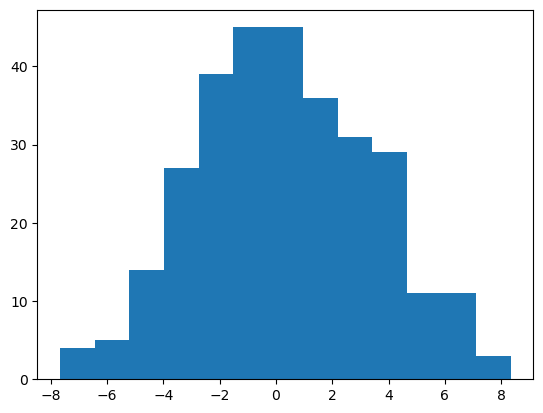

In [249]:
import matplotlib.pyplot as plt
_ = plt.hist(a[2], bins='auto')

In [250]:
df_train.head()

,sentence_text,party_cabinet_sentiment,party,cabinet,sentiment,party_cabinet,text_cleaned,labels
0,Der Verkehrssektor ist eine der Branchen mit d...,FDP_2002_neutral,FDP,2002,neutral,FDP_2002,verkehrssektor branchen größten direkten indir...,1.0
1,Viele andere halten diese Idee dagegen für ung...,PDS/LINKE_2021_left,PDS/LINKE,2021,left,PDS/LINKE_2021,viele halten idee dagegen ungeeignet ziel grun...,0.0
2,Das Europäische Parlament hat in diesem Bereic...,FDP_2002_neutral,FDP,2002,neutral,FDP_2002,europäische parlament bereich kaum entscheidun...,1.0
3,So bietet er das Potenzial einer guten Rendite...,Greens_2021_left,Greens,2021,left,Greens_2021,bietet potenzial guten rendite arbeitgeber inn...,0.0
4,Wir sorgen durch unsere Finanzpolitik für eine...,Greens_2013_right,Greens,2013,right,Greens_2013,sorgen finanzpolitik solide finanzierung öffen...,2.0


In [297]:
def test_doc2vec(dataset, model):
    res = []
    for index, row in dataset.iterrows():
        text = row['text_cleaned']
        infer = model.dv.most_similar(model.infer_vector(text.split()),topn=1)[0][0]
        if infer == 'right':
            res.append(2)
        elif infer == 'left':
            res.append(0)
        else:
            res.append(1)
    return np.array(res)


In [298]:
predicted = test_doc2vec(df_test, model)
labels = np.array(df_test['labels'].tolist())

In [299]:
labels

array([0., 2., 0., ..., 1., 0., 0.])

In [300]:
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted, average=None)
matrix = confusion_matrix(labels, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [301]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.61,0.68,0.56,0.56
1,0.75,0.66,0.86,0.86
2,0.53,0.73,0.42,0.42


In [302]:
round(res_table.mean(axis=0),2)

f1           0.63
precision    0.69
recall       0.61
accuracy     0.61
dtype: float64

# Scaling with Sentence Transformers

## First, some TSDAE pre-training

In [ ]:
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
from torch.utils.data import DataLoader
bert_model = 'results/bert/bert_3class_std/checkpoint-944'
word_embedding_model = models.Transformer(bert_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)
import nltk
nltk.download('punkt')

loading configuration file results/bert/bert_3class_std/checkpoint-944\config.json
Model config BertConfig {
  "_name_or_path": "results/bert/bert_3class_std/checkpoint-944",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading weights file

True

In [ ]:
train_texts = manifesto['text'].tolist()
train_dataset = datasets.DenoisingAutoEncoderDataset(train_texts)
# DataLoader to batch your data
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# Use the denoising auto-encoder loss
train_loss = losses.DenoisingAutoEncoderLoss(model, decoder_name_or_path=bert_model, tie_encoder_decoder=True)

When tie_encoder_decoder=True, the decoder_name_or_path will be invalid.
Didn't find file results/bert/bert_3class_std/checkpoint-944\added_tokens.json. We won't load it.
loading file results/bert/bert_3class_std/checkpoint-944\vocab.txt
loading file results/bert/bert_3class_std/checkpoint-944\tokenizer.json
loading file None
loading file results/bert/bert_3class_std/checkpoint-944\special_tokens_map.json
loading file results/bert/bert_3class_std/checkpoint-944\tokenizer_config.json
loading configuration file results/bert/bert_3class_std/checkpoint-944\config.json
Model config BertConfig {
  "_name_or_path": "results/bert/bert_3class_std/checkpoint-944",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size"

In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    weight_decay=0,
    scheduler='constantlr',
    optimizer_params={'lr': 3e-5},
    show_progress_bar=True
)


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4722 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4722 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4722 [00:00<?, ?it/s]

In [ ]:
model.save(os.path.join("results", "tsdae",  "manifesto_deu"))

Configuration saved in results\tsdae\manifesto_deu/config.json
Model weights saved in results\tsdae\manifesto_deu/pytorch_model.bin
tokenizer config file saved in results\tsdae\manifesto_deu/tokenizer_config.json
Special tokens file saved in results\tsdae\manifesto_deu/special_tokens_map.json


## Scaling - Sentence Transformers

In [31]:
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
bert_model = 'results/tsdae/manifesto_deu/'
word_embedding_model = models.Transformer(bert_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

In [120]:
manifesto_welfare = manifesto[manifesto['code'].isin(['504','505'])].reset_index(drop=True)
manifesto_lr = manifesto[manifesto['sentiment'].isin(['left','right'])].reset_index(drop=True)

In [74]:
manifesto_welfare

,text,cabinet,code,pos,party,code_extract,sentiment,domain,party_cabinet_sentiment,party_cabinet,party_cabinet_domain
0,Wir haben den Familienausgleich durchgreifend ...,1998,504,277,CDU/CSU,504,left,5,CDU/CSU_1998_left,CDU/CSU_1998,CDU/CSU_1998_5
1,Kindergeld bzw Kinderfreibeträge deutlich erhöht,1998,504,278,CDU/CSU,504,left,5,CDU/CSU_1998_left,CDU/CSU_1998,CDU/CSU_1998_5
2,Durch die Einführung eines Erziehungsgeldes un...,1998,504,279,CDU/CSU,504,left,5,CDU/CSU_1998_left,CDU/CSU_1998,CDU/CSU_1998_5
3,Wir haben die rentenrechtliche Anerkennung von...,1998,504,280,CDU/CSU,504,left,5,CDU/CSU_1998_left,CDU/CSU_1998,CDU/CSU_1998_5
4,Bis zum Jahr 2000 wird diese Anerkennung auf 1...,1998,504,281,CDU/CSU,504,left,5,CDU/CSU_1998_left,CDU/CSU_1998,CDU/CSU_1998_5
...,...,...,...,...,...,...,...,...,...,...,...
5182,"Um Armut nachhaltig zu bekämpfen, setzen wir u...",2021,504,1651,SPD,504,left,5,SPD_2021_left,SPD_2021,SPD_2021_5
5183,Gesundheit ist ein globales öffentliches Gut.,2021,504,1652,SPD,504,left,5,SPD_2021_left,SPD_2021,SPD_2021_5
5184,Unsere Schwerpunkte liegen auf dem Aus- und Au...,2021,504,1656,SPD,504,left,5,SPD_2021_left,SPD_2021,SPD_2021_5
5185,sowie auf der gesundheitlichen Bildung und dam...,2021,504,1657,SPD,504,left,5,SPD_2021_left,SPD_2021,SPD_2021_5


In [177]:
len_all = []
for name, group in manifesto.groupby('party_cabinet'):
    text = group['text'].tolist()
    len_all.append(len(text))

In [179]:
relscale = []
embed_dict = {}
absscale = []
for name, group in manifesto_welfare.groupby('party_cabinet'):
    left = group[group.sentiment =='left']['sentiment'].tolist()
    right = group[group.sentiment =='right']['sentiment'].tolist()
    relscale.append((len(right)-len(left))/(len(left)+len(right)))
    len_all = len(manifesto[manifesto.party_cabinet == name]['text'].tolist())
    absscale.append((len(right)-len(left))/len_all)
    text = group['text'].tolist()
    #len_text.append(len(text))
    embeds = model.encode(text, normalize_embeddings=True, device='cuda')
    embed_dict.update({name: embeds})
    

In [164]:
logscale = []
for name, group in manifesto_welfare.groupby('party_cabinet'):
    left = group[group.sentiment =='left']['sentiment'].tolist()
    right = group[group.sentiment =='right']['sentiment'].tolist()
    scale = np.log(len(right)+0.5) - np.log(len(left)+0.5)
    logscale.append(scale)

In [168]:
np.vstack(list(embed_dict.values())).shape

(5187, 768)

In [169]:
document_embed = np.vstack(list(embed_dict.values()))
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
y = enc.fit_transform(np.reshape(manifesto_welfare['sentiment'].tolist(), newshape=(-1,1)))
embedding = umap.UMAP(n_components=1, n_neighbors=1000, n_epochs=1000, metric='cosine', low_memory=True).fit_transform(document_embed, y=y)


In [171]:
emb_mean_dict = {}
for name, group in manifesto_welfare.groupby('party_cabinet'):
    idx = group.index
    embed = embedding[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})

In [172]:
document_embed = np.stack(list(emb_mean_dict.values()))

In [174]:
labels = [name for name, group in manifesto_welfare.groupby('party_cabinet')]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


In [181]:
np.corrcoef(relscale, document_embed[:,0])

array([[1.        , 0.98919626],
       [0.98919626, 1.        ]])

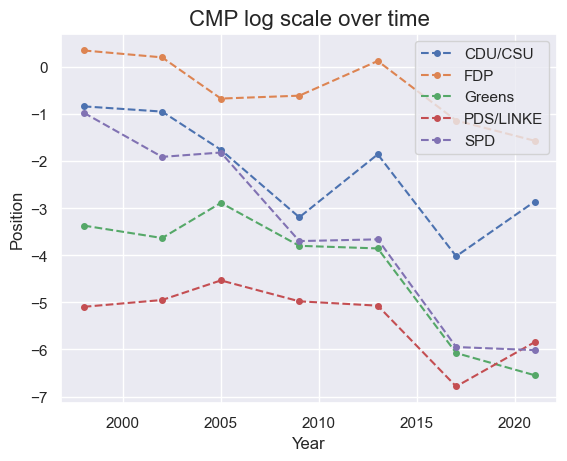

In [187]:
df = pd.DataFrame({'dim1': document_embed[:,0],  'party': party, 'year': year, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) #,'dim2': score[:,1]
import matplotlib.pyplot as plt
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.year,group.lr_log, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend(loc='upper right')
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('CMP log scale over time', fontdict={'fontsize':16})
plt.plot()
plt.savefig('results/tabs and figs/figure5.png', dpi=300)

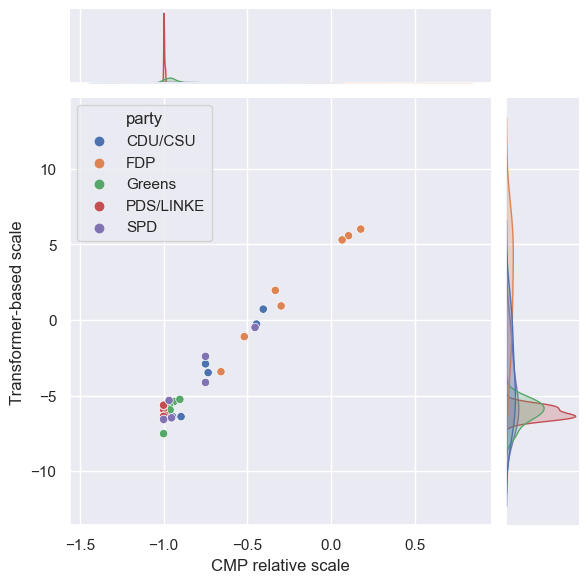

In [185]:
plot = sns.jointplot(data=df, x="lr_prop", y="dim1", hue="party")
plot.set_axis_labels("CMP relative scale", ylabel = "Transformer-based scale")

plt.savefig('results/tabs and figs/figure11.png', dpi=300)

In [489]:
df

,dim1,dim2,party,year,per
0,-1.468210,8.265913,CDU/CSU,1998,0.702703
1,-1.595375,8.885723,CDU/CSU,2002,0.722892
2,-1.657392,9.999141,CDU/CSU,2005,0.875000
3,-3.504555,10.785769,CDU/CSU,2009,0.972973
4,-4.026590,9.540750,CDU/CSU,2013,0.867133
5,-4.177767,9.129083,CDU/CSU,2017,0.988095
6,-3.775728,9.750640,CDU/CSU,2021,0.947867
7,-1.252053,7.292378,FDP,1998,0.411765
8,-0.889911,8.652964,FDP,2002,0.448276
9,-0.705908,9.156885,FDP,2005,0.666667


In [83]:
np.corrcoef(len_text, document_embed[:,0])

array([[ 1.        , -0.95524976],
       [-0.95524976,  1.        ]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=seed_val)
pca_embed = pca.fit_transform(document_embed)

In [182]:
cluster = hdbscan.HDBSCAN(min_cluster_size=3,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(pca_embed)

In [183]:
cluster.labels_

array([-1,  2, -1,  0,  0,  0, -1, -1,  2,  2,  2,  2,  2,  2,  1,  2,  2,
        2,  2,  2, -1, -1,  1,  1, -1,  2,  2,  2, -1,  2, -1, -1,  2,  2,
        2], dtype=int64)

In [140]:
document_embed.shape

(35, 3)

In [498]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(document_embed)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

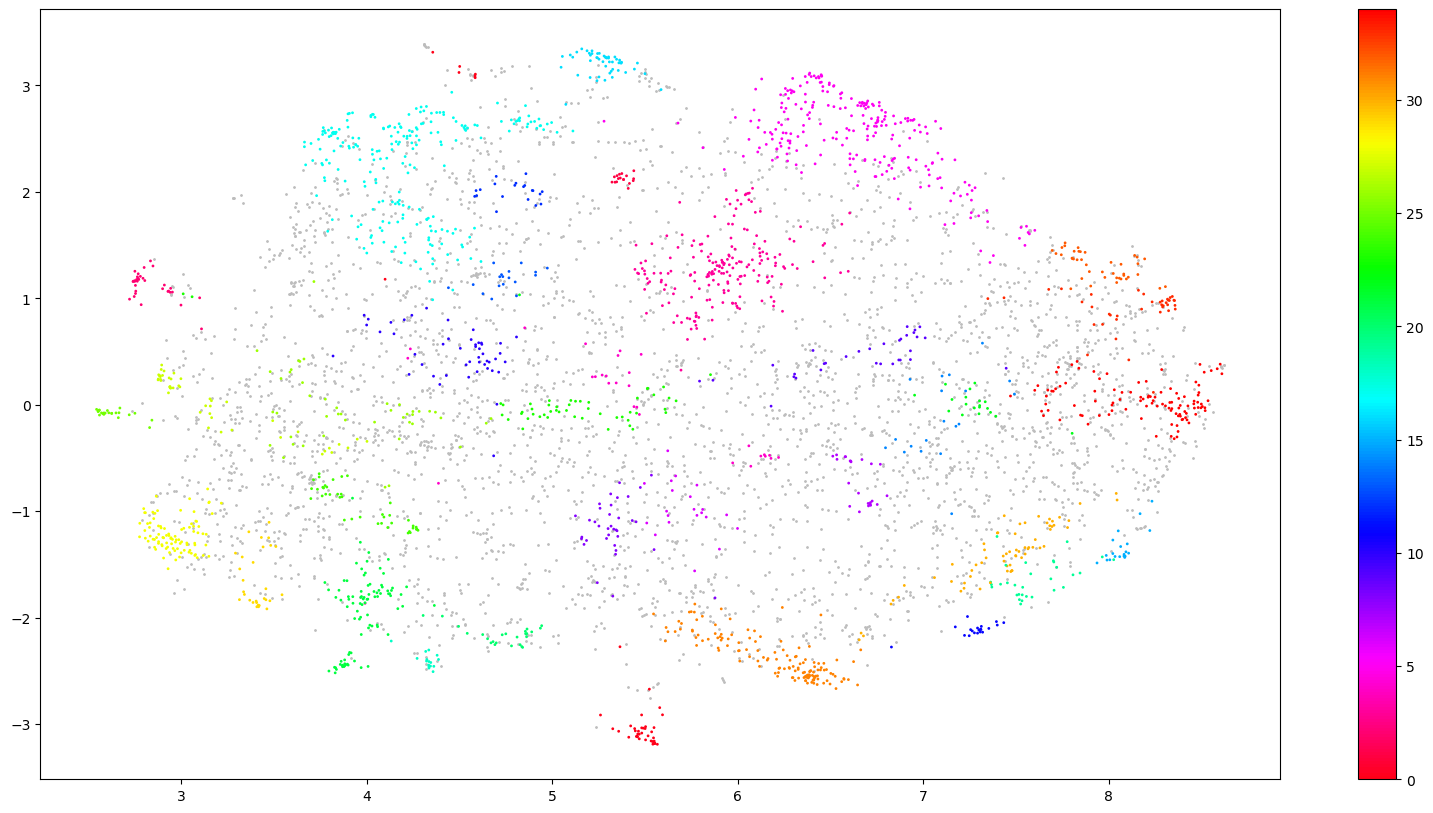

In [502]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='hsv_r')
plt.colorbar()

In [ ]:
docs_df = pd.DataFrame(manifesto_welfare['text'].tolist(), columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [150]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords.words('german')).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(manifesto_welfare['text'].tolist()))

In [151]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,3394
3,2,934
2,1,627
1,0,232


In [148]:
from sklearn.metrics.pairwise import cosine_similarity
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(manifesto_welfare['text'].tolist())
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,5187


In [154]:
top_n_words[2][:20]

[('rente', 0.0386656175170545),
 ('altersvorsorge', 0.030643967244284004),
 ('rentenversicherung', 0.02440442182644493),
 ('kindergeld', 0.022400303538711978),
 ('müssen', 0.020437202206478423),
 ('private', 0.019964771430003126),
 ('gesetzlichen', 0.01860772532188563),
 ('altersarmut', 0.0181979623140137),
 ('alterssicherung', 0.017720215004242906),
 ('grundsicherung', 0.01767733905579135),
 ('gesetzliche', 0.017572755096767607),
 ('menschen', 0.01725232659521793),
 ('vorsorge', 0.016646262579743335),
 ('leistungen', 0.016580193036088507),
 ('alter', 0.01594378531548992),
 ('kinder', 0.015586618065077601),
 ('einführen', 0.015517385748632678),
 ('rentner', 0.015214105919124971),
 ('euro', 0.014711914568041448),
 ('einkommen', 0.014703566052634778)]

In [ ]:
topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens").fit(docs)

In [470]:
document_embed = np.stack(list(emb_mean_dict.values()))

In [464]:
len_text = (2*(len_text- np.min(len_text))/(np.max(len_text) - np.min(len_text)))-1
document_embed = np.multiply(document_embed, len_text.reshape(document_embed.shape[0],-1))

In [447]:
len_text

array([-0.01081081,  0.05783133,  0.575     ,  0.90810811,  0.54825175,
        0.95952381,  0.82274882, -1.        , -0.87586207, -0.13333333,
       -0.19220779, -0.81086957,  0.18148148,  0.41818182,  0.89634146,
        0.92916667,  0.83495146,  0.93982301,  0.93388889,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        0.98577406,  1.        ,  0.99344894,  0.07272727,  0.575     ,
        0.575     ,  0.9442623 ,  0.92013423,  1.        ,  1.        ])

## Scaling - Predict sentiments and use it as guidance

In [33]:
cap_deu = pd.read_csv('data/CAP/cap_data_cleaned.csv', encoding='utf-8')

In [34]:
cap_deu['party'] = cap_deu['party_name'].apply(functions.party_new)

In [536]:
cap_deu.groupby('party').count()

,Unnamed: 0,election_year,party_name,party_id,manifesto_id,sentence_id,cap_topic,cap_subtopic,header,junk,eu_dummy,sentence_text
party,,,,,,,,,,,,
CDU/CSU,13236,13236,13236,13236,13236,13236,13236,13236,13236,13236,13236,13236
FDP,19419,19419,19419,19419,19419,19419,19419,19419,19419,19419,19419,19419
GRUENEN,18853,18853,18853,18853,18853,18853,18853,18853,18853,18853,18853,18853
PDS/DIE LINKE,6857,6857,6857,6857,6857,6857,6857,6857,6857,6857,6857,6857
SPD,16825,16825,16825,16825,16825,16825,16825,16825,16825,16825,16825,16825


In [35]:
cap_deu = cap_deu[['election_year','party','cap_topic','cap_subtopic','eu_dummy','sentence_text']]
cap_deu.head()

,election_year,party,cap_topic,cap_subtopic,eu_dummy,sentence_text
0,1949,SPD,99,99,0,Für ein freies Deutschland
1,1949,SPD,99,99,0,Wählerinnen und Wähler!
2,1949,SPD,99,99,0,"Am 14. August entscheidet XX darüber, wie ein ..."
3,1949,SPD,20,2099,0,Heute ist unser land geteilt.
4,1949,SPD,20,2099,0,Swjetrussland hat seine Besatzungszone separiert.


In [36]:
cap_deu['party_cabinet'] = cap_deu.party.str.cat(others=[cap_deu.election_year.astype(str)], sep='_')

In [120]:
cap_deu_macro = cap_deu.loc[(cap_deu.cap_subtopic == 1302) & (cap_deu.election_year >= 1991),:].reset_index(drop=True)


In [121]:
cap_deu_macro.groupby('party_cabinet').count()

,election_year,party,cap_topic,cap_subtopic,eu_dummy,sentence_text
party_cabinet,,,,,,
CDU/CSU_1994,7,7,7,7,7,7
CDU/CSU_2002,1,1,1,1,1,1
CDU/CSU_2005,4,4,4,4,4,4
CDU/CSU_2009,2,2,2,2,2,2
FDP_1994,5,5,5,5,5,5
FDP_1998,23,23,23,23,23,23
FDP_2002,13,13,13,13,13,13
FDP_2005,4,4,4,4,4,4
FDP_2009,13,13,13,13,13,13


In [39]:
embed_dict = {}
len_text = []
for name, group in cap_deu.groupby('party_cabinet'):
    text = group['sentence_text'].tolist()
    #left = group[group.sentiment =='left']['sentiment'].tolist()
    #right = group[group.sentiment =='right']['sentiment'].tolist()
    #len_text.append(len(left)/(len(left)+len(right)))
    embeds = model.encode(text, device='cuda')
    embed_dict.update({name: embeds})

In [131]:
len(cap_deu)

75190

In [40]:
document_embed = np.vstack(list(embed_dict.values()))
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
y = enc.fit_transform(np.reshape(cap_deu['cap_topic'].tolist(), newshape=(-1,1)))
embedding = umap.UMAP(n_components=2, n_neighbors=1000, n_epochs=1000, metric='cosine', low_memory=True).fit_transform(document_embed, y=y)


In [42]:
emb_mean_dict = {}
for name, group in cap_deu.groupby('party_cabinet'):
    idx = group.index
    embed = embedding[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})

In [43]:
document_embed = np.stack(list(emb_mean_dict.values()))

In [44]:
labels = [name for name, group in cap_deu.groupby('party_cabinet')]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


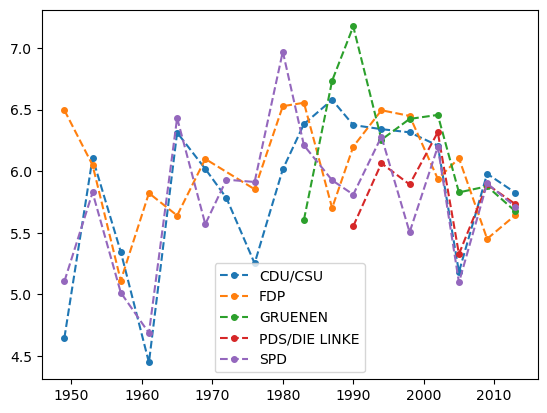

In [46]:
df = pd.DataFrame({'dim1': document_embed[:,1], 'party': party, 'year': year}) #,'dim2': score[:,1]
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.year, group.dim1, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend()

plt.show()